In [1]:
import numpy as np
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
from Bio.PDB import MMCIFParser

In [2]:
dir_base = "."
dir_af3 = f"{dir_base}/af3_prediction/minidys"
dir_seq = f"{dir_base}/aa_seq"

# sequence of 2 intein subunits
intein_1 = "CLDLKTQVQTPQGMKEISNIQVGDLVLSNTGYNEVLNVFPKSKKKSYKITLEDGKEIICSEEHLFPTQTGEMNISGGLKEGMCLYVK"
intein_2 = "MLKKILKIEELDERELIDIEVSGNHLFYANDILTHN"

# select model 0 in AF3 prediction for visualization and analysis
model_af3 = 0

In [3]:
construct = "3"
n_af3 = f"fold_2024_08_29_midi_dys{construct}_200aa"

In [4]:
with open(f'{dir_seq}/MD{construct}.txt', 'r') as file:
    seq = file.read()
seq_5p, seq_3p = seq.split(':')

l_seq_5p = len(seq_5p)
l_seq_3p = len(seq_3p)

seq_5p = seq_5p[-200:]
seq_3p = seq_3p[:200]

assert intein_1 in seq_5p
assert intein_2 in seq_3p

f_name = [f for f in os.listdir(f'{dir_af3}/{n_af3}') if f'_full_data_{model_af3}.json' in f][0]
with open(f'{dir_af3}/{n_af3}/{f_name}', 'r') as f:
    conf = json.load(f)

## Visualize PAE

In [5]:
pae = np.array(conf['pae'])
assert len(seq_5p) + len(seq_3p) == pae.shape[0]

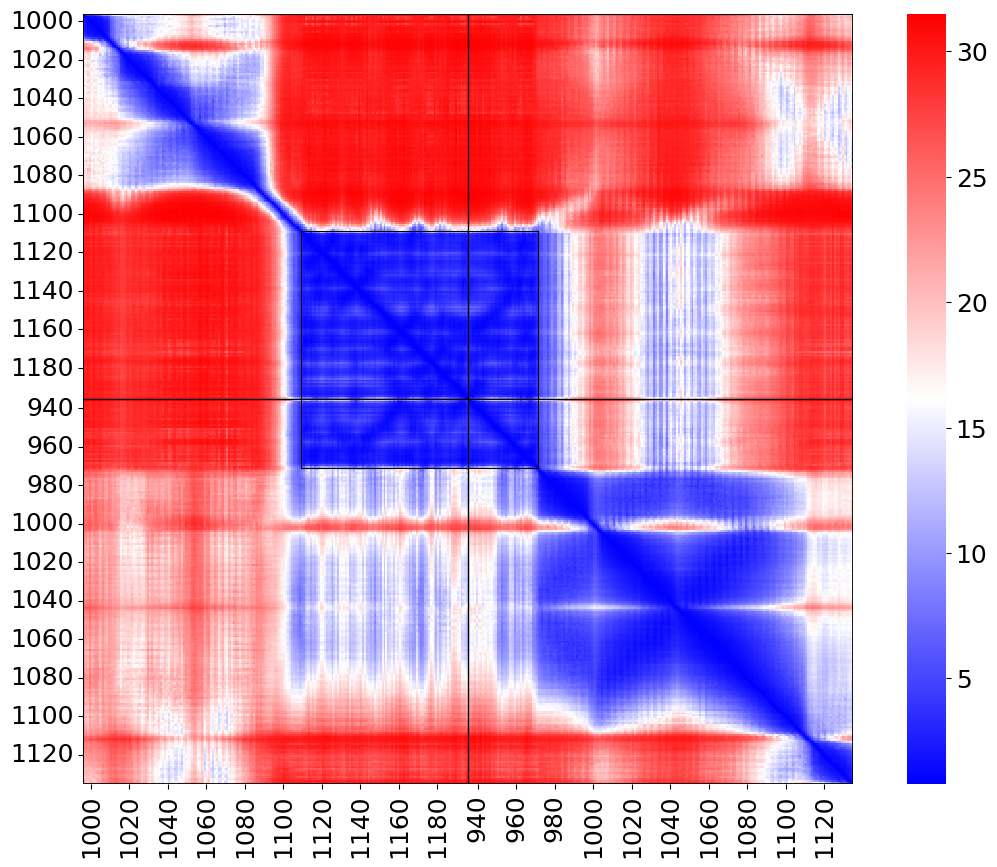

In [6]:
pos = [-(200-len(intein_1)), (200-len(intein_2))] #aroudn the intein

aa_i = len(seq_5p) - len(intein_1) + pos[0]
aa_f = len(seq_5p) + len(intein_2) + pos[1]

i_sep = len(seq_5p)-aa_i

x_values = [i+(l_seq_5p-len(seq_5p))+1 for i in range(len(seq_5p))] + [i+(l_seq_3p-len(seq_3p))+1 for i in range(len(seq_3p))]
y_values = [i+(l_seq_5p-len(seq_5p))+1 for i in range(len(seq_5p))] + [i+(l_seq_3p-len(seq_3p))+1 for i in range(len(seq_3p))]

x_ticks = [i for i, val in enumerate(x_values) if val % 20 == 0]
y_ticks = [i for i, val in enumerate(y_values) if val % 20 == 0]


plt.figure(figsize=(14, 10))
ax = sns.heatmap(
    pae[aa_i:aa_f, aa_i:aa_f], 
    cmap='bwr', square=True,
    xticklabels=x_values, yticklabels=y_values
)

ax.axhline(y=i_sep, color='black', linewidth=1)
ax.axvline(x=i_sep, color='black', linewidth=1)

# draw the intein
ax.plot([i_sep-len(intein_1), i_sep+len(intein_2)],  [i_sep-len(intein_1),i_sep-len(intein_1)], color='black', linewidth=0.75)
ax.plot([i_sep-len(intein_1), i_sep+len(intein_2)],  [i_sep+len(intein_2), i_sep+len(intein_2)], color='black', linewidth=0.75)
ax.plot([i_sep-len(intein_1), i_sep-len(intein_1)],  [i_sep-len(intein_1), i_sep+len(intein_2)], color='black', linewidth=0.75)
ax.plot([i_sep+len(intein_2), i_sep+len(intein_2)],  [i_sep-len(intein_1), i_sep+len(intein_2)], color='black', linewidth=0.75)

ax.plot([0,400],  [0,0], color='black', linewidth=0.75)
ax.plot([0,0],  [0,400], color='black', linewidth=0.75)
ax.plot([400,400],  [0,400], color='black', linewidth=2)
ax.plot([0,400],  [400,400], color='black', linewidth=2)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=18)
#cbar.set_label('PAE', fontsize=20, fontweight='bold', labelpad=20)
#cbar.ax.yaxis.set_label_position('left')

# Set custom x-tick labels and positions
ax.set_xticks(x_ticks)
ax.set_xticklabels([x_values[i] for i in x_ticks], fontsize=18)
# Set custom y-tick labels and positions
ax.set_yticks(y_ticks)
ax.set_yticklabels([y_values[i] for i in y_ticks], fontsize=18)


plt.show()

## calculate mean pLDDT

In [7]:
# Function to extract B-factors for Cα atoms
def extract_ca_b_factors(cif_file):
    # Initialize the parser
    parser = MMCIFParser(QUIET=True)
    
    # Parse the structure from the CIF file
    structure = parser.get_structure('structure', cif_file)
    
    # List to store B-factors
    b_factors = []

    # Iterate through all atoms in the structure
    for model in structure:
        for chain in model:
            for residue in chain:
                if residue.has_id('CA'):
                    # Get the CA atom
                    ca_atom = residue['CA']
                    # Append the B-factor to the list
                    b_factors.append(ca_atom.get_bfactor())
    
    # Convert the list to a numpy array
    b_factors_array = np.array(b_factors)
    
    return b_factors_array

f_name_cif = f_name.replace(f'_full_data_{model_af3}.json', f'_model_{model_af3}.cif')
f_name_cif = f'{dir_af3}/{n_af3}/{f_name_cif}'
plddt = extract_ca_b_factors(f_name_cif)

print("mean pLDDT: ", plddt[i_sep-len(intein_1):i_sep+len(intein_2)].mean())

mean pLDDT:  91.18991869918698


## calculate contact probabilities

In [8]:
threshold=10
pae_inter = pae[i_sep+len(intein_2):, :i_sep-len(intein_1)]

def percentage_pae_threshold(pae_inter, threshold=10):
    return np.sum([pae_inter<threshold]) / (pae_inter.shape[0]*pae_inter.shape[1]) * 100

percent_pae_inter = percentage_pae_threshold(pae_inter, threshold)
print(f"{round(percent_pae_inter, 2)}% PAE less than {threshold} Angstrom in minidys{construct} prediction")

1.12% PAE less than 10 Angstrom in minidys3 prediction


In [9]:
contact = np.array(conf['contact_probs'])
con_inter = contact[i_sep+len(intein_2):, :i_sep-len(intein_1)]
pae_inter = (pae[i_sep+len(intein_2):, :i_sep-len(intein_1)] < 10)

con_prob = np.mean(pae_inter*con_inter)
print(f"contact probability: {round(con_prob,6)}")

contact probability: 0.000625
